# Analyse des spécificités des genres

Dans ce carnet est proposée une analyse des spécificités des genres, en relation avec le temps et le lieu de naissance.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns

In [2]:
### Librairies déjà installées avec Python
import pprint
import sqlite3 as sql

In [3]:
from fanalysis.ca import CA 
from fanalysis.mca import MCA

### Importer les données à analyser

In [4]:
### Se connecter à la base de données dans laquelle on va insérer
# le résultat de la requête SPARQL
cn = sql.connect('../../data/conseil_national_import.db')
cn

In [7]:
qr = """
SELECT wp.personne_uri, wp.nom_prenom, wp.genre_code as genre,
 max(wp.annee_naissance) AS annee_naissance,
   max(wl.code_lieu) AS lieu
FROM wdt_personnes wp 
   JOIN wdt_lieu_naissance wln
	 ON wl.id_li = wp.fk_lieu_id
     GROUP BY wp.personne_uri, nom_prenom
"""

In [8]:
### Vérifier que les données ont été importées correctement
cur = cn.cursor()
l = cur.execute(qr).fetchall()
print(len(l))
l[:3]

OperationalError: no such column: wl.code_lieu

In [17]:
### Créer un DataFrame contenant les données
df_orig = pd.DataFrame(l, columns=['uri', 'nom', 'genre', 'annee_nais', 
                     'langue'])
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884 entries, 0 to 883
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   uri         884 non-null    object
 1   nom         884 non-null    object
 2   genre       884 non-null    object
 3   annee_nais  884 non-null    int64 
 4   langue      884 non-null    object
dtypes: int64(1), object(4)
memory usage: 34.7+ KB


In [18]:
### Distribution des genres
df_orig.groupby(by='genre').size().sort_values(ascending=False)

genre
M    683
F    201
dtype: int64

### Codage par périodes de 15 ans

In [19]:
### On transforme le type de valeur de la colonne BirthYear
# de objet à entier
df_orig['annee_nais'] = df_orig['annee_nais'].astype(int)

In [21]:
### Créer une copie indépendante du DataFrame (attention aux copies de variables qui sont seulement des alias) 
cdf_p = df_orig[df_orig['annee_nais'] < 2020].copy(deep=True)
cdf_p.head(3)

,uri,nom,genre,annee_nais,langue
0,http://www.wikidata.org/entity/Q1029622,Regula Rytz,F,1962,ALL
1,http://www.wikidata.org/entity/Q1039793,Carl Miville-Seiler,M,1921,ALL
2,http://www.wikidata.org/entity/Q105607582,Fabienne Bugnon,F,1959,FR


In [22]:
### Année minimale et maximale dans la population
min(cdf_p['annee_nais']), max(cdf_p['annee_nais'])

(1901, 1994)

In [24]:
### Créer une liste d'années pour séparer en périodes de 15 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_15 = list(range(1901, 1995, 15))
l_15[:5],l_15[-5:]

([1901, 1916, 1931, 1946, 1961], [1931, 1946, 1961, 1976, 1991])

In [25]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

cdf_p['periodes'] = pd.cut(cdf_p['annee_nais'], l_15, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_p['periodes'] = cdf_p['periodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_p.head(3)

,uri,nom,genre,annee_nais,langue,periodes
0,http://www.wikidata.org/entity/Q1029622,Regula Rytz,F,1962,ALL,1961-1975
1,http://www.wikidata.org/entity/Q1039793,Carl Miville-Seiler,M,1921,ALL,1916-1930
2,http://www.wikidata.org/entity/Q105607582,Fabienne Bugnon,F,1959,FR,1946-1960


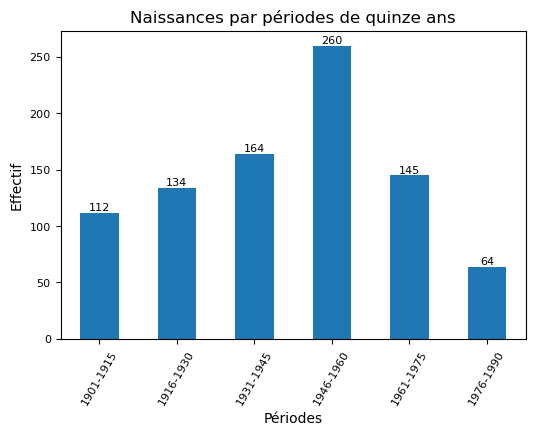

In [26]:
ax = cdf_p.groupby(by='periodes', observed=True).size()\
      .plot(kind='bar',rot=60, fontsize=8, figsize=(6,4))

ax.bar_label(ax.containers[0], fontsize=8)

plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Naissances par périodes de quinze ans')
plt.show()

### Distributions des genres par périodes

In [27]:
### Tableau de contingence
X = "periodes"  # "0"
Y = "genre"

ddf = cdf_p[[Y,X]].pivot_table(index=Y,columns=X,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf

periodes,1901-1915,1916-1930,1931-1945,1946-1960,1961-1975,1976-1990,Total
genre,,,,,,,
F,2,9,33,77,47,30,198
M,110,125,131,183,98,34,681
Total,112,134,164,260,145,64,879


In [28]:
### Production du tableau à analyser
D = ddf.iloc[:-1,:-1].copy(deep=True)
D

periodes,1901-1915,1916-1930,1931-1945,1946-1960,1961-1975,1976-1990
genre,,,,,,
F,2,9,33,77,47,30
M,110,125,131,183,98,34


In [29]:
## Nombre de modalités ligne
K = D.shape[0]
## Nombre de modalités colonnes
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 2 , 6 ), effectif: 879 , nombre max. facteurs: 1


In [30]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic, ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D, method='cramer')
print('Cramer: ', vc)

Chi2 : 84.69484677003085 , dof : 5
p-value : 8.722529690974464e-17
phi2 = inertie (variance totale) : 0.09635363682597366
Cramer:  0.3104088220814184


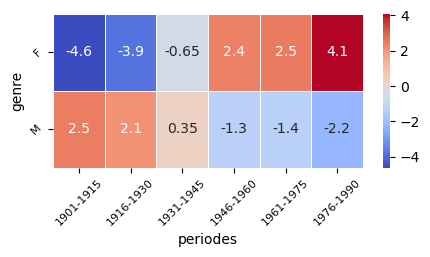

In [31]:
### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D.values-dfe)/np.sqrt(dfe),2))
residus_ponderes.columns= D.columns
residus_ponderes.index=D.index


fig, ax = plt.subplots(figsize=(5,2))         
# Sample figsize in inches
g = sns.heatmap(residus_ponderes, annot=residus_ponderes, cmap="coolwarm", linewidths=.5, ax=ax)
labelsx = residus_ponderes.columns
labelsy = residus_ponderes.index
xt = g.set_xticklabels(labelsx, rotation=45, fontsize=8)
yt = g.set_yticklabels(labelsy, rotation=45, fontsize=8)

plt.show()


#### Commentaire

Comme la variable 'gender' a deux modalités un seul facteur résumé la variance et une analyse factorielle n'est pas utile.

### Distributions des genres par origines

In [33]:
### Tableau de contingence
X = "genre"
Y = "langue"

ddf = cdf_p[[Y,X]].pivot_table(index=Y,columns=X,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf

genre,F,M,Total
langue,,,
ALL,137,458,595
FR,57,184,241
IT,7,41,48
Total,201,683,884


Si cette table de contingence concerne l'ensemble de la population, on utilise pour la suite la même population que pour l'analyse précédente, limitée donc dans le temps et sans le genre 'A'.

In [35]:
### Tableau de contingence
X = "genre"
Y = "langue"

ddf = cdf_p[[Y,X]].pivot_table(index=Y,columns=X,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf

genre,F,M,Total
langue,,,
ALL,137,458,595
FR,57,184,241
IT,7,41,48
Total,201,683,884


In [36]:
### Production du tableau à analyser
D = ddf.iloc[:-1,:-1].copy(deep=True)
D

genre,F,M
langue,,
ALL,137,458
FR,57,184
IT,7,41


In [37]:
## Nombre de modalités ligne
K = D.shape[0]
## Nombre de modalités colonnes
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 3 , 2 ), effectif: 884 , nombre max. facteurs: 1


In [38]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic, ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D, method='cramer')
print('Cramer: ', vc)

Chi2 : 1.959348019170526 , dof : 2
p-value : 0.3754334666164452
phi2 = inertie (variance totale) : 0.002216457035260776
Cramer:  0.047079263325383244


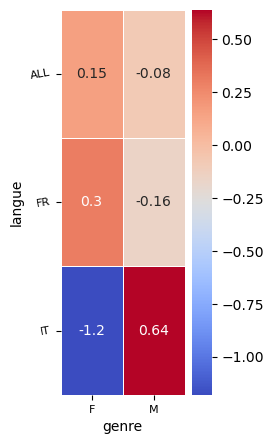

In [39]:
### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D.values-dfe)/np.sqrt(dfe),2))
residus_ponderes.columns= D.columns
residus_ponderes.index=D.index


fig, ax = plt.subplots(figsize=(2,5))         
# Sample figsize in inches
g = sns.heatmap(residus_ponderes, annot=residus_ponderes, 
                cmap="coolwarm", linewidths=.5, ax=ax)
labelsx = residus_ponderes.columns
labelsy = residus_ponderes.index
xt = g.set_xticklabels(labelsx, rotation=0, fontsize=8)
yt = g.set_yticklabels(labelsy, rotation=10, fontsize=8)



plt.show()


### Commentaire

XXXXX

## Analyser le lien entre genre+période et l'aire géographique

Cette analyse plus fine permet de comparer trois variable mais dans une logique bivariée

In [43]:
cdf_p.periodes = cdf_p.periodes.astype("str")
cdf_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884 entries, 0 to 883
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   uri         884 non-null    object
 1   nom         884 non-null    object
 2   genre       884 non-null    object
 3   annee_nais  884 non-null    int32 
 4   langue      884 non-null    object
 5   periodes    884 non-null    object
dtypes: int32(1), object(5)
memory usage: 38.1+ KB


In [44]:
cdf_p['genre_periodes'] = cdf_p.apply(lambda x: \
                    x.periodes + '_' + x.genre, axis=1)
cdf_p.head()

,uri,nom,genre,annee_nais,langue,periodes,genre_periodes
0,http://www.wikidata.org/entity/Q1029622,Regula Rytz,F,1962,ALL,1961-1975,1961-1975_F
1,http://www.wikidata.org/entity/Q1039793,Carl Miville-Seiler,M,1921,ALL,1916-1930,1916-1930_M
2,http://www.wikidata.org/entity/Q105607582,Fabienne Bugnon,F,1959,FR,1946-1960,1946-1960_F
3,http://www.wikidata.org/entity/Q105750072,Madeleine Bernasconi,F,1939,FR,1931-1945,1931-1945_F
4,http://www.wikidata.org/entity/Q106371824,Otto G. Loretan,M,1946,ALL,1946-1960,1946-1960_M


In [45]:
cdf_p.groupby(by='genre_periodes').size()


genre_periodes
1901-1915_F      2
1901-1915_M    110
1916-1930_F      9
1916-1930_M    125
1931-1945_F     33
1931-1945_M    131
1946-1960_F     77
1946-1960_M    183
1961-1975_F     47
1961-1975_M     98
1976-1990_F     30
1976-1990_M     34
nan_F            3
nan_M            2
dtype: int64

In [46]:
### Tableau de contingence
X = "genre_periodes"
Y = "langue"

ddf = cdf_p[[Y,X]].pivot_table(index=Y,columns=X,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf

genre_periodes,1901-1915_F,1901-1915_M,1916-1930_F,1916-1930_M,1931-1945_F,1931-1945_M,1946-1960_F,1946-1960_M,1961-1975_F,1961-1975_M,1976-1990_F,1976-1990_M,nan_F,nan_M,Total
langue,,,,,,,,,,,,,,,
ALL,2,80,3,97,22,80,57,124,30,60,20,15,3,2,595
FR,0,26,6,25,11,41,17,48,14,31,9,13,0,0,241
IT,0,4,0,3,0,10,3,11,3,7,1,6,0,0,48
Total,2,110,9,125,33,131,77,183,47,98,30,34,3,2,884


In [59]:
### Liste construite manuellement à partir de cette liste
# print(ddf.index.to_list())

li = ['ALL', 'FR', 'IT']

In [60]:
lc = ddf.columns.to_list()[:-1]

In [61]:
D = ddf.loc[li,lc].copy(deep=True)
D

genre_periodes,1901-1915_F,1901-1915_M,1916-1930_F,1916-1930_M,1931-1945_F,1931-1945_M,1946-1960_F,1946-1960_M,1961-1975_F,1961-1975_M,1976-1990_F,1976-1990_M,nan_F,nan_M
langue,,,,,,,,,,,,,,
ALL,2,80,3,97,22,80,57,124,30,60,20,15,3,2
FR,0,26,6,25,11,41,17,48,14,31,9,13,0,0
IT,0,4,0,3,0,10,3,11,3,7,1,6,0,0


In [80]:
## Nombre de modalités ligne
K = D.shape[0]
## Nombre de modalités colonnes
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 3 , 14 ), effectif: 884 , nombre max. facteurs: 2


## commentaires

comme le nombre max. de facteurs est limité à 2 dans mon carnet, je vais uniquement faire des visualisation en 2D et renoncer à la 3D.

In [81]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic, ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D, method='cramer')
print('Cramer: ', vc)

Chi2 : 41.39015410521539 , dof : 26
p-value : 0.028340357979230294
phi2 = inertie (variance totale) : 0.04682144129549252
Cramer:  0.15300562292852593


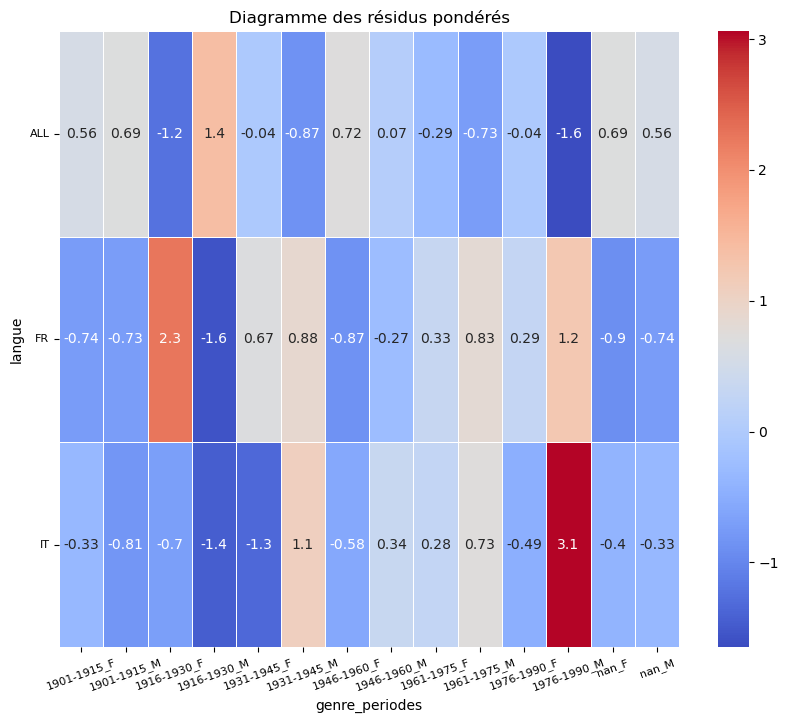

In [82]:
### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D.values-dfe)/np.sqrt(dfe),2))
residus_ponderes.columns= D.columns
residus_ponderes.index=D.index


fig, ax = plt.subplots(figsize=(10,8))         
# Sample figsize in inches
g = sns.heatmap(residus_ponderes, annot=residus_ponderes, 
                cmap="coolwarm", linewidths=.5, ax=ax)
labelsx = residus_ponderes.columns
labelsy = residus_ponderes.index
xt = g.set_xticklabels(labelsx, rotation=20, fontsize=8)
yt = g.set_yticklabels(labelsy, rotation=0, fontsize=8)


g.set_title('Diagramme des résidus pondérés')

plt.savefig('images/genre_periode_aire_resid_ponderes.jpg', bbox_inches='tight')
plt.show()


In [83]:
afc = CA(row_labels=D.index,col_labels=D.columns)
afc.fit(D.values)

CA(col_labels=Index(['1901-1915_F', '1901-1915_M', '1916-1930_F', '1916-1930_M',
       '1931-1945_F', '1931-1945_M', '1946-1960_F', '1946-1960_M',
       '1961-1975_F', '1961-1975_M', '1976-1990_F', '1976-1990_M', 'nan_F',
       'nan_M'],
      dtype='object', name='genre_periodes'),
   row_labels=Index(['ALL', 'FR', 'IT'], dtype='object', name='langue'))

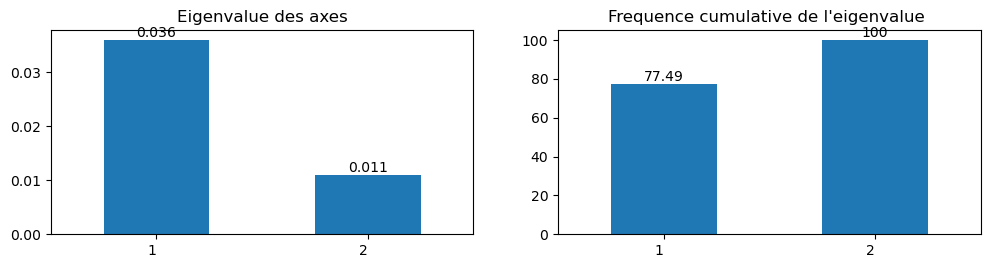

In [84]:
eig = pd.DataFrame(afc.eig_)

r1 = round(eig.iloc[0], 3)
r2 = round(eig.iloc[2], 2)
s=list(range(1,len(r1)+1))
r1.index=s
r2.index=s

# https://www.statology.org/pandas-subplots/
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

ax1 = r1.plot(kind='bar', ax=axes[0], title='Eigenvalue des axes')
ax2 = r2.plot(kind='bar', ax=axes[1], title="Frequence cumulative de l'eigenvalue ")


ax1.bar_label(ax1.containers[0])
ax2.bar_label(ax2.containers[0])


# Met les valeurs xticks en vertical
fig.autofmt_xdate(rotation=0)
plt.show()

### Graphiques et interprétation du premier plan factoriel

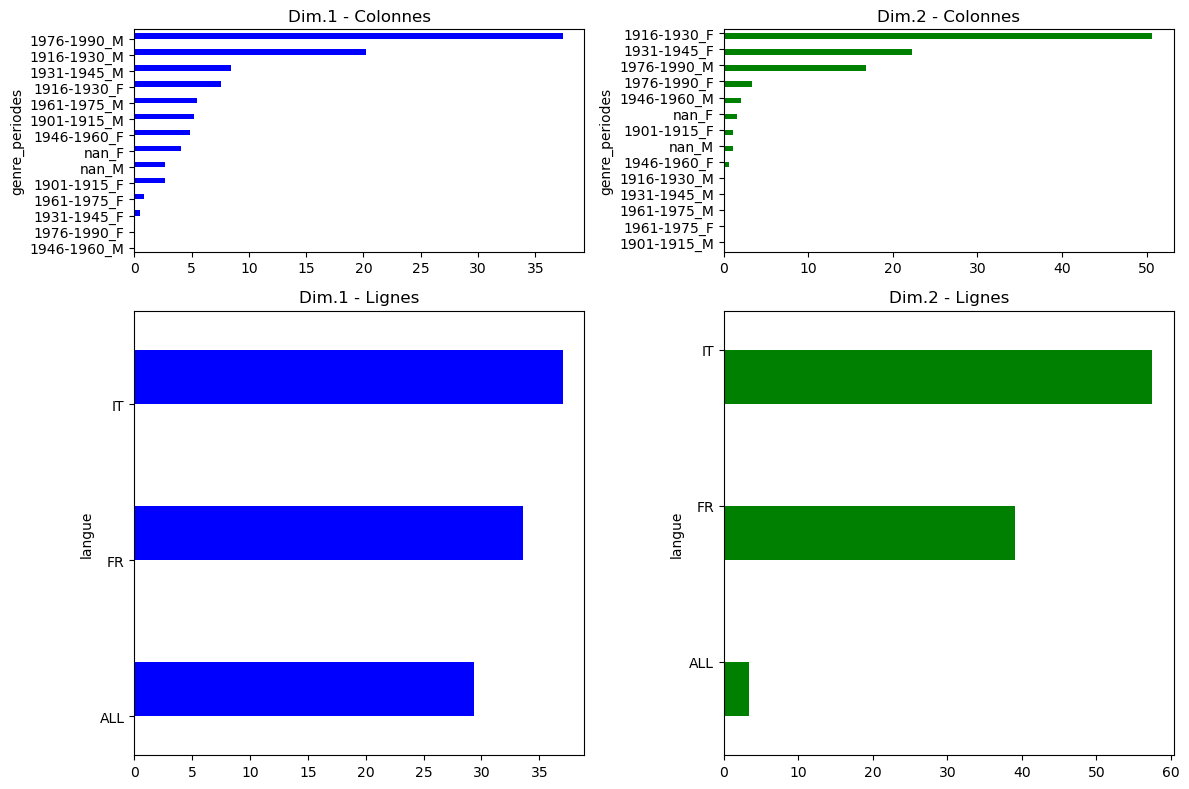

In [114]:
import matplotlib.pyplot as plt

# Informations sur les contributions des colonnes
df_col = afc.col_topandas()[['col_contrib_dim1', 'col_contrib_dim2']]

r1_col = df_col.iloc[:,0]
r2_col = df_col.iloc[:,1]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8),
                         gridspec_kw={'height_ratios': [1, 2]})

# Ajustement de l'espacement entre les barres
bar_width = 0.35
index = np.arange(len(r1_col))

r1_col.sort_values().plot(kind='barh', ax=axes[0,0], title='Dim.1 - Colonnes', width=bar_width, color='b', position=0)
r2_col.sort_values().plot(kind='barh', ax=axes[0,1], title='Dim.2 - Colonnes', width=bar_width, color='g', position=1)

# Informations sur les contributions des lignes
df_row = afc.row_topandas()[['row_contrib_dim1', 'row_contrib_dim2']]

r1_row = df_row.iloc[:,0]
r2_row = df_row.iloc[:,1]

r1_row.sort_values().plot(kind='barh', ax=axes[1,0], title='Dim.1 - Lignes', width=bar_width, color='b', position=0)
r2_row.sort_values().plot(kind='barh', ax=axes[1,1], title='Dim.2 - Lignes', width=bar_width, color='g', position=1)

# Ajustement de l'espacement vertical entre les sous-graphiques
plt.subplots_adjust(hspace=1)  # Ajustez la valeur selon vos préférences

plt.tight_layout()
plt.show()


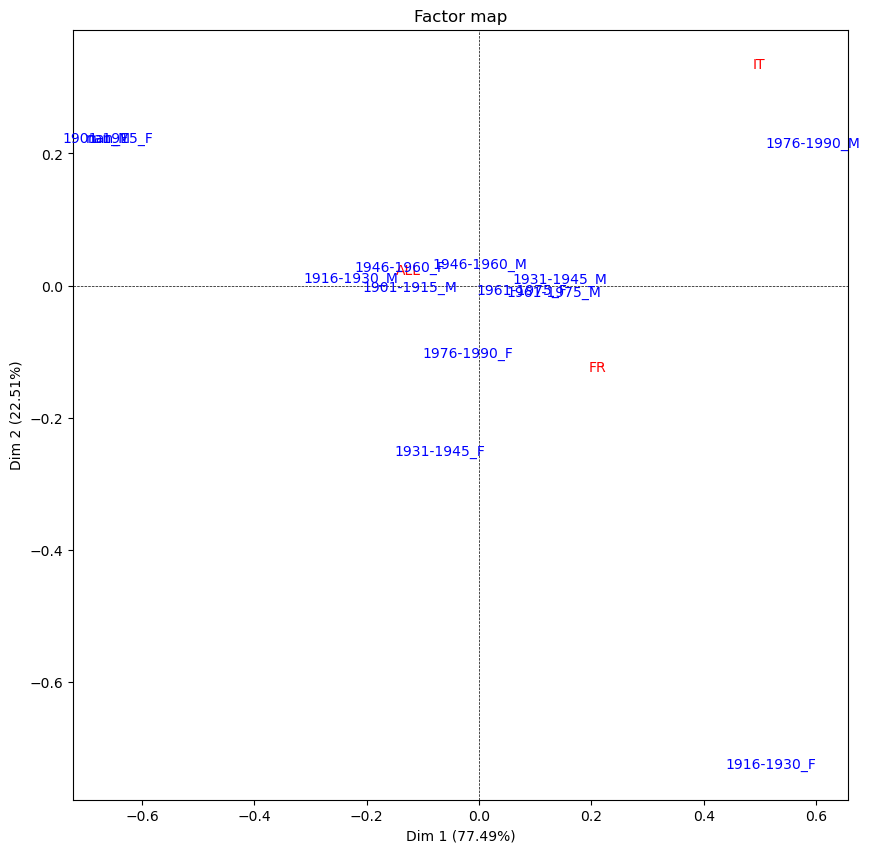

In [115]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=1,num_y_axis=2,figsize=(10,10))

### Représenter l'autre plan factoriel

## commentaire

j'ai un problème pour représenter l'autre plan factoriel car je n'ai que 2 dimensions, dû au nombre max. de facteurs

In [116]:
### Informations sur les cosinus carrés. Ces valeurs expriment 
# la qualité de représentation d'une modalité sur l'axe correspondant

### Colonnes
df = afc.col_topandas()[['col_cos2_dim1',
                         'col_cos2_dim2',
                         'col_cos2_dim3']]

r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,6), 
                         gridspec_kw={'height_ratios': [1, 2]})

r1.sort_values().plot(kind='barh', ax=axes[0,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[0,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[0,2], title='Dim.3')

### Lignes
df = afc.row_topandas()[['row_cos2_dim1',
                         'row_cos2_dim2',
                         'row_cos2_dim3']]
r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

r1.sort_values().plot(kind='barh', ax=axes[1,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[1,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[1,2], title='Dim.3')

plt.tight_layout()
plt.show()

KeyError: "['col_cos2_dim3'] not in index"

In [117]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=2,num_y_axis=3,figsize=(10,10))

IndexError: index 2 is out of bounds for axis 1 with size 2

<Figure size 1000x1000 with 0 Axes>

### Commentaire

Cette analyse factorielle met en évidence, en relation avec le diagramme des résidus pondérés qui permet de la contrôler, les moments de présence féminine significative dans les générations présentes dans les  différentes régions géoraphiques